In [1]:
import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler

import tensorflow as tf

In [2]:
config = {
        # Arquitectura
        "result_name": "lstm_5q_share_withmonth",
        "lstm_units_1": 64,
        "lstm_units_2": 32,
        "dense_units": 16,
        "dropout_rate": 0.3,
        "seed": 42,  # Para reproducibilidad
        # Entrenamiento
        "epochs": 150,
        "batch_size": 64,
        "early_stopping_patience": 30,
        "learning_rate": None,  # Si querés usar Adam con tasa específica

        # Regularización
        "l2_lambda": 0.001,

        # Optimizador
        "optimizer": "rmsprop",  # adam, sgd, rmsprop, etc.

        # Preprocesamiento
        "scaler_name": "robust",  # standard o robust

        # Ventana temporal
        "window_size": 6,
        "feature_cols" : ['tn', 
                          
                          #'tn_lag1', 
                          #'tn_lag6', 
                          #'tn_lag12', 
                          #'tn_diff1', 
                          #'tn_diff6',
                        #'rolling_mean6', 
                        #'rolling_std6', 
                        # 'rolling_max3', 
                        # 'rolling_min3',
                        # 'rolling_max6',
                        # 'rolling_min6',
                        #"size"
                        #"quantil_std",
                        #"sin_mes",
                        #"quarter",
                        ],
        "products_to_train": None,  # Filtrar productos entre 50 y 150
    }


In [3]:
df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")

productos_ok = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/product_id_apredecir201912.txt", sep="\t")

df = df[df["product_id"].isin(productos_ok["product_id"])]

periodos = df["periodo"].unique()
ultimos_6_meses = list(periodos[-6:])
std6 = df.query("periodo in @ultimos_6_meses").groupby("product_id")["tn"].std().reset_index().fillna(0)
std6.columns = ["product_id", "std6"]
std6.sort_values(by="std6", ascending=False, inplace=True)
std6["grupo"] = pd.qcut(std6["std6"], 5, labels=False)
productos = list(df["product_id"].unique())
productos.sort()
# Filtrar productos entre 50 y 150
max_std = std6["grupo"].max()
#std6.loc[std6["product_id"].isin(productos[:50]), "grupo"] = max_std + 1  # Asegurar que los productos filtrados tengan un quantil distinto
grupo_dict = {int(r.product_id): int(r.grupo) for i, r in std6.iterrows()}



In [4]:
# import pandas as pd

# df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")

# # Seleccionar los últimos 6 meses (ajusté a 6 como en el nombre de la variable, aunque tu lista tenía 12)
# periodos = df["periodo"].unique()
# ultimos_6_meses = list(periodos[-6:])  # Cambiado a 6 para coincidir con el nombre

# # Calcular media y desviación estándar para cada producto
# stats_6 = df.query("periodo in @ultimos_6_meses").groupby("product_id")["tn"].agg(['std', 'mean']).reset_index().fillna(0)

# # Calcular coeficiente de variación (en porcentaje)
# stats_6['cv'] = (stats_6['std'] / stats_6['mean']) * 100
# # Manejar casos donde la media es 0 (cv infinito)
# stats_6['cv'] = stats_6['cv'].replace([float('inf'), -float('inf')], 0)

# # Ordenar por CV
# stats_6.sort_values(by="cv", ascending=False, inplace=True)

# # Crear quantiles basados en el CV
# stats_6["quantil_cv"] = pd.qcut(stats_6["cv"], 5, labels=False) 

# # Crear el diccionario final
# cv_dict = {int(r.product_id): int(r.quantil_cv) for i, r in stats_6.iterrows()}

In [5]:
# Cargar de nuevo por claridad

# Agrupar y sumar las toneladas por producto y período
df_grouped = df.groupby(["product_id", "periodo"]).agg({"tn": "sum"}).reset_index()

# # Calcular el total de toneladas por período
# total_por_periodo = df_grouped.groupby("periodo")["tn"].transform("sum")

# # Calcular la ponderación (porcentaje) de cada producto respecto al total de su período
# df_grouped["tn"] = (df_grouped["tn"] / total_por_periodo) * 100

# # Opcional: redondear los resultados para mejor presentación
# df_grouped["tn"] = df_grouped["tn"].round(2)


# Encontrar el primer período para cada producto
min_periods = df_grouped.groupby("product_id")["periodo"].min().reset_index()

# Crear todas las combinaciones relevantes
all_periods = df_grouped["periodo"].unique()
all_periods.sort()

# Usar un merge cartesiano con filtro posterior
df = (
    min_periods.merge(pd.DataFrame({"periodo": all_periods}), how="cross")
    .query("periodo_y >= periodo_x")
    .drop(columns="periodo_x")
    .rename(columns={"periodo_y": "periodo"})
    .merge(df_grouped, on=["product_id", "periodo"], how="left")
    .fillna(0)
    .sort_values(["product_id", "periodo"])
    .reset_index(drop=True)
)

In [6]:


# Agregación mensual por producto
# df = df.groupby(["product_id", "periodo"]).agg({"tn": "sum"}).sort_values(["product_id", "periodo"]).reset_index()
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")

# Crear características por producto
def agregar_features(df):
    df = df.copy()
    df = df.sort_values(["product_id", "periodo"])
    # quantil de la desviación estándar de los últimos 6 meses
    df["grupo"] = df.product_id.map(grupo_dict).fillna(0)
    df["grupo"] = df["grupo"].astype(int)
    # Crear features con groupby + transform
    df["tn_lag1"] = df.groupby("product_id")["tn"].shift(1)
    #df["tn_lag6"] = df.groupby("product_id")["tn"].shift(6)
    #df["tn_lag12"] = df.groupby("product_id")["tn"].shift(12)

    df["tn_diff1"] = df["tn"] - df["tn_lag1"]
    #df["tn_diff6"] = df["tn"] - df["tn_lag6"]
    #df["size"] = df.groupby("product_id")["tn"].transform("size")
    
    df["sin_mes"] = df["periodo"].dt.month.apply(lambda x: np.sin(2 * np.pi * x / 12))
    df["quarter"] = df["periodo"].dt.quarter
    df["month"] = df["periodo"].dt.month

    df["rolling_mean6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).mean())
    df["rolling_std6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).std())
    
    # df["rolling_max3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).max())
    # df["rolling_min3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).min())
    # df["rolling_max6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).max())
    # df["rolling_min6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).min())

    return df

df_features = agregar_features(df).fillna(0)
df = df_features.copy()
print(df_features.shape)

(22375, 11)


In [7]:
df_features

,product_id,periodo,tn,grupo,tn_lag1,tn_diff1,sin_mes,quarter,month,rolling_mean6,rolling_std6
0,20001,2017-01-01,934.77222,4,0.00000,0.00000,5.000000e-01,1,1,0.000000,0.000000
1,20001,2017-02-01,798.01620,4,934.77222,-136.75602,8.660254e-01,1,2,0.000000,0.000000
2,20001,2017-03-01,1303.35771,4,798.01620,505.34151,1.000000e+00,1,3,0.000000,0.000000
3,20001,2017-04-01,1069.96130,4,1303.35771,-233.39641,8.660254e-01,2,4,0.000000,0.000000
4,20001,2017-05-01,1502.20132,4,1069.96130,432.24002,5.000000e-01,2,5,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
22370,21276,2019-08-01,0.01265,0,0.00223,0.01042,-8.660254e-01,3,8,0.000000,0.000000
22371,21276,2019-09-01,0.01856,0,0.01265,0.00591,-1.000000e+00,3,9,0.062132,0.050285
22372,21276,2019-10-01,0.02079,0,0.01856,0.00223,-8.660254e-01,4,10,0.044810,0.042656
22373,21276,2019-11-01,0.03341,0,0.02079,0.01262,-5.000000e-01,4,11,0.031320,0.032689


In [8]:
# Último período disponible
ultimo_mes = df_features["periodo"].max()

# Definir los 3 meses anteriores
ultimos_3_meses = pd.date_range(end=ultimo_mes - pd.DateOffset(months=1), periods=3, freq='MS')

# Filtrar productos con datos en al menos 3 de esos meses
df_filtrado = df_features[df_features["periodo"].isin(ultimos_3_meses)]

# Contar cuántos meses tiene cada producto
conteo_por_producto = df_filtrado[df_filtrado["tn"] > 0].groupby("product_id").size()

# Seleccionar productos válidos
productos_validos = conteo_por_producto[conteo_por_producto >= 3].index

# Filtrar el dataframe original
df_features = df_features[df_features["product_id"].isin(productos_validos)].copy()
print(df_features.shape)

(22375, 11)


In [9]:
df_test = df_features[df_features["periodo"] == pd.to_datetime(201912, format="%Y%m")].copy()
df_features[df_features["periodo"].isin(pd.to_datetime([201911, 201912], format="%Y%m")) ]

,product_id,periodo,tn,grupo,tn_lag1,tn_diff1,sin_mes,quarter,month,rolling_mean6,rolling_std6
34,20001,2019-11-01,1397.37231,4,1561.50552,-164.13321,-5.000000e-01,4,11,1483.594937,239.063446
35,20001,2019-12-01,1504.68856,4,1397.37231,107.31625,-2.449294e-16,4,12,1444.859933,229.267460
70,20002,2019-11-01,1423.57739,4,1979.53635,-555.95896,-5.000000e-01,4,11,1152.218297,418.103201
71,20002,2019-12-01,1087.30855,4,1423.57739,-336.26884,-2.449294e-16,4,12,1216.982983,426.327986
106,20003,2019-11-01,948.29393,4,1081.36645,-133.07252,-5.000000e-01,4,11,775.408012,200.444440
...,...,...,...,...,...,...,...,...,...,...,...
22354,21266,2019-12-01,0.05121,0,0.06713,-0.01592,-2.449294e-16,4,12,0.056698,0.036011
22363,21267,2019-11-01,0.04052,0,0.09676,-0.05624,-5.000000e-01,4,11,0.088908,0.080884
22364,21267,2019-12-01,0.01569,0,0.04052,-0.02483,-2.449294e-16,4,12,0.054910,0.027947
22373,21276,2019-11-01,0.03341,0,0.02079,0.01262,-5.000000e-01,4,11,0.031320,0.032689


In [10]:
# ================================
# 2. SCALING Y VENTANAS TEMPORALES
# ================================

window_size = config["window_size"]

def get_window_size(q):
  window_size = 3 if q >= 3 else 6
  return window_size

scaler_name = config["scaler_name"]

feature_cols = config["feature_cols"]

# Agrupar por producto
productos = df_features["product_id"].unique()
productos = list(productos)
scalers = {}  # Guardamos los scalers por producto


In [11]:

# ================================
# 3. TRAIN / TEST SPLIT
# ================================
from sklearn.model_selection import train_test_split
grupos = df_features["grupo"].unique()
grupos.sort()
sets = {}
modelos = {}
metricas = {}
seed = config.get("seed", 42)
for grupo in grupos:
    window_size = get_window_size(grupo)
    df_grupo = df_features[df_features["grupo"] == grupo].copy()
    sets[grupo] = {}
    X, y, productos_list = [], [], []
    periodos = []
    productos_train = df_grupo["product_id"].unique()
    
    for producto in productos_train:
        df_prod = df_features[df_features["product_id"] == producto].copy()
        df_prod = df_prod.sort_values('periodo')
        if len(df_prod) < window_size + 2:
            continue

        scaler = StandardScaler() if scaler_name == "standard" else RobustScaler()
        scaled_features = scaler.fit_transform(df_prod[feature_cols])
        scalers[producto] = scaler

        for i in range(window_size, len(df_prod) - 2):
            X_window = scaled_features[i - window_size:i]
            y_target = scaled_features[i][0]  # TN target
            mes_ultimo_valor = df_prod.iloc[i - 1]["month"]  # el último mes dentro de la ventana
            quarter_ultimo_valor = df_prod.iloc[i - 1]["quarter"]
            mes_scaled = (mes_ultimo_valor - 1) / 11  # Normalizado a [0, 1]
            
            quarter_scaled = (quarter_ultimo_valor - 1) / 3  # quarter ∈ [0, 3]
            
                # Crear una feature adicional repetida en la ventana
            mes_feature = np.full((window_size, 1), mes_scaled)
            quarter_feature = np.full((window_size, 1), quarter_scaled)
            
            X_with_extra = np.concatenate([X_window, mes_feature, quarter_feature], axis=1)
            
            X.append(X_with_extra)
            y.append(y_target)
            productos_list.append(producto)
            periodo_target = df_prod.iloc[i + 2]["periodo"]
            periodos.append(periodo_target)
    

    
    
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    productos_list = np.array(productos_list)
    periodos = np.array(periodos)

    # Ahora sí, aplicá las máscaras
    train_mask = periodos <= pd.to_datetime("2019-09-30")
    test_mask = periodos == pd.to_datetime("2019-10-01")

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    productos_test = productos_list[test_mask]
    
    sets[grupo]["X"] = X
    sets[grupo]["y"] = y
    sets[grupo]["X_train"] = X_train
    sets[grupo]["X_test"] = X_test
    sets[grupo]["y_train"] = y_train
    sets[grupo]["y_test"] = y_test
    sets[grupo]["productos_train"] = productos_train
    print(f"grupo {grupo}: {len(productos_train)} productos, {len(X_train)} muestras de entrenamiento, {len(X_test)} muestras de test")
    
    
    
# ================================


grupo 0: 156 productos, 2363 muestras de entrenamiento, 122 muestras de test
grupo 1: 156 productos, 2947 muestras de entrenamiento, 132 muestras de test
grupo 2: 156 productos, 2668 muestras de entrenamiento, 129 muestras de test
grupo 3: 156 productos, 3362 muestras de entrenamiento, 149 muestras de test
grupo 4: 156 productos, 3749 muestras de entrenamiento, 146 muestras de test


In [15]:

# ================================
# 4. MODELO LSTM
# ================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

tf.random.set_seed(seed)

def custom_mape_loss(y_true, y_pred):
    """
    Pérdida personalizada: Mean Absolute Percentage Error (MAPE) modificado
    donde el denominador es la suma total de los valores reales.
    """
    numerator = tf.reduce_sum(tf.abs(y_true - y_pred))
    denominator = tf.reduce_sum(tf.abs(y_true))
    return numerator / (denominator + tf.keras.backend.epsilon())  # Evita división por cero

for grupo in sets:
    window_size = get_window_size(grupo)
    set_data = sets[grupo]
    X_train = set_data["X_train"]
    y_train = set_data["y_train"]
    X_test = set_data["X_test"]
    y_test = set_data["y_test"]
    
    
    
    l2_lambda = config["l2_lambda"]
    optimizer = config["optimizer"]
    epochs = config["epochs"]
    batch_size = config["batch_size"]
    early_stopping_patience = config["early_stopping_patience"]

    def get_reg(l2_lambda):
        return l2(l2_lambda) if l2_lambda > 0 else None
    reg = regularizers.l1_l2(l1=3.3692472030315245e-07, l2=8.7876011262569e-08)
    n_features = X_train.shape[2] 
    model = Sequential([
        LSTM(32, activation='tanh', return_sequences=True,recurrent_dropout=0.26612587287797906,
             input_shape=(window_size, n_features),
             kernel_regularizer=reg
             ),
        Dropout(0.18703491200890998),
        LSTM(32, return_sequences=True, activation='relu', recurrent_dropout=0.10895054417461136, kernel_regularizer=reg),
        Dense(8, activation='relu',kernel_regularizer=reg),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss=custom_mape_loss, metrics=custom_mape_loss)

    callbacks = [
         EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=15)
    ]

    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1,
    )
    modelos[grupo] = model
    # Evaluar el modelo
    
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    metricas[grupo] = {
        "loss": loss,
        "mae": mae
    }

Epoch 1/150
37/37 [==============================] - 16s 165ms/step - loss: 5.9865 - custom_mape_loss: 5.9863 - val_loss: 5.8289 - val_custom_mape_loss: 5.8304 - lr: 0.0010
Epoch 2/150
37/37 [==============================] - 5s 137ms/step - loss: 5.9391 - custom_mape_loss: 5.9388 - val_loss: 5.5856 - val_custom_mape_loss: 5.5887 - lr: 0.0010
Epoch 3/150
37/37 [==============================] - 5s 131ms/step - loss: 5.8983 - custom_mape_loss: 5.8981 - val_loss: 5.6190 - val_custom_mape_loss: 5.6230 - lr: 0.0010
Epoch 4/150
37/37 [==============================] - 5s 131ms/step - loss: 5.8638 - custom_mape_loss: 5.8637 - val_loss: 5.5855 - val_custom_mape_loss: 5.5917 - lr: 0.0010
Epoch 5/150
37/37 [==============================] - 5s 129ms/step - loss: 5.8364 - custom_mape_loss: 5.8361 - val_loss: 5.5802 - val_custom_mape_loss: 5.5895 - lr: 0.0010
Epoch 6/150
37/37 [==============================] - 5s 135ms/step - loss: 5.8099 - custom_mape_loss: 5.8095 - val_loss: 5.5547 - val_custo

In [16]:
def predecir_todos_t2(df_features_full, scalers, feature_cols):
    """
    Predice tn en t+2 para todos los productos que tengan suficientes datos.

    Args:
        df_features_full (pd.DataFrame): dataframe completo con features
        model: modelo LSTM ya entrenado
        scalers (dict): diccionario con los StandardScaler por producto
        feature_cols (list): lista de columnas de features
        window_size (int): tamaño de la ventana temporal

    Returns:
        pd.DataFrame: dataframe con columnas ["product_id", "tn_t2_pred"]
    """
    productos = df_features_full["product_id"].unique()
    resultados = []
    errores = []
    for pid in productos:
        y_pred = None
        df_prod = df_features_full[df_features_full["product_id"] == pid]
        grupo = df_prod["grupo"].iloc[0] if not df_prod.empty else 0
        window_size = get_window_size(grupo)
        if len(df_prod) < window_size:
            y_pred = np.mean(df_prod["tn"][-12:])  # Valor por defecto si falla la predicción
            resultados.append({"product_id": pid, "tn_t2_pred": y_pred})
            continue  # no hay suficientes datos

        try:
            ultimos = df_prod[feature_cols].iloc[-window_size:]
            scaler = scalers[pid]
            ultimos_scaled = scaler.transform(ultimos)

            # Agregar la feature extra
            mes_ultimo_valor = df_prod.iloc[-1]["month"]
            quarter_ultimo_valor = df_prod.iloc[-1]["quarter"]
            
            mes_scaled = (mes_ultimo_valor - 1) / 11
            quarter_scaled = (quarter_ultimo_valor - 1) / 3


            mes_feature = np.full((window_size, 1), mes_scaled)
            quarter_feature = np.full((window_size, 1), quarter_scaled)

            X_new = np.concatenate([ultimos_scaled, mes_feature, quarter_feature], axis=1).reshape(1, window_size, -1)
            model = modelos[int(df_prod["grupo"].iloc[0])]  # Obtener el modelo según el quantil
            y_pred_scaled = model.predict(X_new, verbose=0)

            # Desescalar
            tn_mean = scaler.center_[0]
            tn_std = scaler.scale_[0]
            y_pred = y_pred_scaled[0][0] * tn_std + tn_mean

            

        except Exception as e:
            errores.append(pid)
            #print(f"Error al predecir producto {pid}: {e}")
            
        if y_pred is None or y_pred < 0:
            y_pred = np.mean(df_prod["tn"][-12:])  # Valor por defecto si falla la predicción

            
        resultados.append({"product_id": pid, "tn_t2_pred": y_pred})

    print(f"Errores en predicciones: {errores} de {len(productos)} productos")
    return pd.DataFrame(resultados), errores





In [17]:
df_preds_t2, errores = predecir_todos_t2(
    df_features_full=df_features,
    scalers=scalers,
    feature_cols=feature_cols,
    #window_size=window_size
)
print(f"Errores: {len(errores)} de {len(df_features['product_id'].unique())} productos")
print(df_preds_t2.head())

Errores en predicciones: [20127, 20210, 20621, 20662, 20673, 20711, 20720, 20732, 20774, 20827, 20904, 20910, 20912, 20927, 20933, 21006, 21007, 21035, 21039, 21079, 21109, 21111, 21112, 21114, 21119, 21140, 21227] de 780 productos
Errores: 27 de 780 productos
   product_id   tn_t2_pred
0       20001  [1387.1389]
1       20002  [1094.6986]
2       20003   [803.6937]
3       20004   [649.9756]
4       20005  [615.47546]


In [18]:
df_preds_t2

,product_id,tn_t2_pred
0,20001,[1387.1389]
1,20002,[1094.6986]
2,20003,[803.6937]
3,20004,[649.9756]
4,20005,[615.47546]
...,...,...
775,21263,[0.02887841]
776,21265,[0.042210963]
777,21266,[0.047470763]
778,21267,[0.057873696]


In [19]:
dforig = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")
total_diciembre = dforig.query("periodo == 201912")["tn"].sum()
df_preds_t2["tn_t2_pred"] = df_preds_t2["tn_t2_pred"]

In [20]:
df_final = df_test.merge(df_preds_t2, on="product_id", how="left")
df_final

,product_id,periodo,tn,grupo,tn_lag1,tn_diff1,sin_mes,quarter,month,rolling_mean6,rolling_std6,tn_t2_pred
0,20001,2019-12-01,1504.68856,4,1397.37231,107.31625,-2.449294e-16,4,12,1444.859933,229.267460,[1387.1389]
1,20002,2019-12-01,1087.30855,4,1423.57739,-336.26884,-2.449294e-16,4,12,1216.982983,426.327986,[1094.6986]
2,20003,2019-12-01,892.50129,4,948.29393,-55.79264,-2.449294e-16,4,12,835.102808,187.119671,[803.6937]
3,20004,2019-12-01,637.90002,4,723.94206,-86.04204,-2.449294e-16,4,12,707.642135,210.228042,[649.9756]
4,20005,2019-12-01,593.24443,4,606.91173,-13.66730,-2.449294e-16,4,12,773.672883,176.802640,[615.47546]
...,...,...,...,...,...,...,...,...,...,...,...,...
775,21263,2019-12-01,0.01270,0,0.03247,-0.01977,-2.449294e-16,4,12,0.022817,0.011760,[0.02887841]
776,21265,2019-12-01,0.05007,0,0.06600,-0.01593,-2.449294e-16,4,12,0.048168,0.035791,[0.042210963]
777,21266,2019-12-01,0.05121,0,0.06713,-0.01592,-2.449294e-16,4,12,0.056698,0.036011,[0.047470763]
778,21267,2019-12-01,0.01569,0,0.04052,-0.02483,-2.449294e-16,4,12,0.054910,0.027947,[0.057873696]


In [21]:
numerador = (df_final["tn"]- df_final["tn_t2_pred"]).abs().sum()
denominador = df_final["tn"].sum()
porcentaje_error = (numerador / denominador)
porcentaje_error

array([0.31193483], dtype=float32)

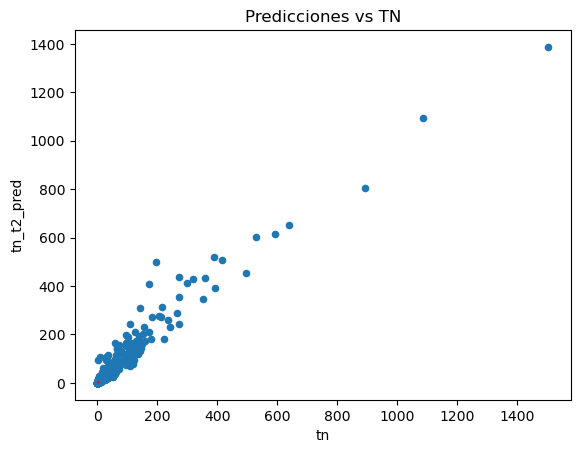

In [22]:
import matplotlib.pyplot as plt
df_final.plot(kind="scatter", x="tn", y="tn_t2_pred", title="Predicciones vs TN")
plt.plot([0, 6], [0, 6], 'r--')
plt.show()

In [23]:
import plotly.graph_objects as go

# Crear el gráfico de dispersión
fig = go.Figure()

# Añadir los puntos de dispersión con el product_id en el hover
fig.add_trace(go.Scatter(
    x=df_final["tn"],
    y=df_final["tn_t2_pred"],
    mode='markers',
    name='Datos',
    customdata=df_final["product_id"],  # Pasamos el product_id como dato adicional
    hovertemplate=(
        "<b>TN Real</b>: %{x}<br>"
        "<b>TN Predicho</b>: %{y}<br>"
        "<b>Product ID</b>: %{customdata}<br>"
        "<extra></extra>"  # Elimina información adicional automática
    ),
    marker=dict(size=8, opacity=0.7)  # Opcional: ajustar tamaño y transparencia
))

# Añadir la línea de referencia y=x
fig.add_trace(go.Scatter(
    x=[0, 1400],
    y=[0, 1400],
    mode='lines',
    name='y = x',
    line=dict(color='red', dash='dash')
))

# Configurar el diseño del gráfico para que sea cuadrado
fig.update_layout(
    title='Predicciones vs TN',
    xaxis_title='TN Real',
    yaxis_title='TN Predicho',
    showlegend=True,
    # Forzar misma escala en ejes X e Y
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1),
    # Tamaño cuadrado (opcional)
    width=600,
    height=600,
    # Rango fijo para ambos ejes (opcional)
    xaxis_range=[0, 1500],
    yaxis_range=[0, 1500]
)

# Mostrar el gráfico
fig.show()

In [24]:
print(df_final["tn_t2_pred"].sum(),"|",df_final["tn"].sum())

[31150.934] | 25145.252080000002


In [25]:
df_final["error"] = (df_final["tn"] - df_final["tn_t2_pred"]).abs()
df_final["error_relativo"] = df_final["error"] / df_final["tn"]
df_final.sort_values(by="error", ascending=False, inplace=True)
df_final[["product_id" ,"tn", "tn_t2_pred", "error", "error_relativo"]].head(20)


,product_id,tn,tn_t2_pred,error,error_relativo
7,20008,195.36854,[498.25372],[302.8852],[1.5503273]
11,20012,173.13004,[407.38376],[234.25372],[1.3530507]
13,20014,272.02812,[439.05917],[167.03107],[0.61402136]
17,20018,141.63570,[308.17484],[166.53914],[1.1758274]
27,20028,109.92618,[243.54106],[133.61488],[1.2154965]
6,20007,390.43432,[520.34326],[129.90894],[0.33272928]
0,20001,1504.68856,[1387.1389],[117.54968],[0.078122266]
14,20015,297.27663,[412.40094],[115.1243],[0.38726318]
12,20013,318.09141,[429.99405],[111.90265],[0.351794]
40,20044,59.61747,[163.0712],[103.45373],[1.7352922]


In [26]:
sellin = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")

In [27]:

# prod = 20995
# prod_s = sellin[sellin["product_id"] == prod]
# prod_s["periodo"] = pd.to_datetime(prod_s["periodo"], format='%Y%m')
# prod_s = prod_s.groupby("periodo").agg({"tn": "sum"}).reset_index()
# #prod_s.plot(kind="line", x="periodo", y="tn", title="TN por periodo para producto 20002")

# import matplotlib.pyplot as plt

# ax = plt.gca()
# prod_s.plot(kind="line", x="periodo", y="tn", title=f"TN por periodo para producto {prod}", ax=ax)
# #plt.axhline(y=813.82, color='red', linestyle='--', label='predict')
# prediccion = df_final[df_final["product_id"] == prod]["tn_t2_pred"].values[0]
# plt.scatter(prod_s["periodo"].iloc[-1], prediccion, color='red', label='prediccion')
# plt.legend()
# plt.show()

In [28]:
df_final["volumen_cuartil"] = pd.qcut(df_final["tn"], q=10, labels=False)


In [29]:
print(df_final.groupby("volumen_cuartil")[["error"]].sum())

                       error
volumen_cuartil             
0                 [58.48562]
1                [104.11715]
2                [192.54189]
3                 [159.3838]
4                [307.52478]
5                [420.04825]
6                 [360.8734]
7                [771.74615]
8                [1660.9097]
9                 [3808.051]


In [30]:
metricas

{0: {'loss': 5.223657131195068, 'mae': 5.252960681915283},
 1: {'loss': 5.14612340927124, 'mae': 5.202258110046387},
 2: {'loss': 5.2921061515808105, 'mae': 5.452145576477051},
 3: {'loss': 2.7693138122558594, 'mae': 2.7694931030273438},
 4: {'loss': 2.6786465644836426, 'mae': 2.6946804523468018}}

In [31]:
df_preds_t2, errores = predecir_todos_t2(
    df_features_full=df,
    scalers=scalers,
    feature_cols=feature_cols,
    #window_size=window_size
)

Errores en predicciones: [20127, 20210, 20621, 20662, 20673, 20711, 20720, 20732, 20774, 20827, 20904, 20910, 20912, 20927, 20933, 21006, 21007, 21035, 21039, 21079, 21109, 21111, 21112, 21114, 21119, 21140, 21227] de 780 productos


In [32]:
total_diciembre = sellin.query("periodo == 201912")["tn"].sum()

In [52]:
productos_ok = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/product_id_apredecir201912.txt", sep="\t")

def aplanar_lista(lista):
    lista_plana = []
    for elemento in lista:
        if isinstance(elemento, np.ndarray):  # Si es una lista, aplana recursivamente
            lista_plana.append(elemento[0])  # Tomar el primer elemento de la lista
        else:
            lista_plana.append(elemento)
            print(type(elemento))
    return lista_plana



pred = pd.DataFrame({"product_id": df_preds_t2["product_id"],  "tn": df_preds_t2["tn_t2_pred"]})
#pred["tn"] = pred["tn"] * total_diciembre/100 *0.9
pred = pred[pred["product_id"].isin(productos_ok["product_id"])]
result_name = config["result_name"]
result_name = "LSTM_Q5_withmonth_opt"  # IGNORE
# Ejemplo con niveles mixtos
pred["tn"] = aplanar_lista(pred["tn"].to_list())  # Asegurar que no haya valores negativos
pred.to_csv(f"{result_name}.csv", sep=",", index=False)

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl

In [53]:
pred

,product_id,tn
0,20001,1387.138916
1,20002,1094.698608
2,20003,803.693726
3,20004,649.975586
4,20005,615.475464
...,...,...
775,21263,0.028878
776,21265,0.042211
777,21266,0.047471
778,21267,0.057874


In [ ]:
df_preds_t2[df_preds_t2["product_id"].isin(productos_ok["product_id"])].product_id.nunique()

780

In [ ]:
pred.drop_duplicates(subset=["product_id"], inplace=True)

In [ ]:
pred

,product_id,tn
0,20001,1282.423369
1,20002,895.847687
2,20003,712.372982
3,20004,482.133539
4,20005,437.671462
...,...,...
775,21263,0.011982
776,21265,0.024516
777,21266,0.029611
778,21267,0.025542
